In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the data
file_path = '/content/drive/MyDrive/New prediction/C55006/tle-55006_55006 Fixed Position Velocity.csv'
data = pd.read_csv(file_path)

# Convert 'Time (UTCG)' to datetime and set it as the index
data['Time (UTCG)'] = pd.to_datetime(data['Time (UTCG)'])
data.set_index('Time (UTCG)', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Convert the data to a supervised learning problem
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

look_back = 60  # Number of previous time steps to use as input variables to predict the next time period
X, y = create_dataset(scaled_data, look_back)


In [ ]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, X.shape[2])))
model.add(LSTM(50))
model.add(Dense(X.shape[2]))  # Output layer with the same number of features

model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/30
3279/3279 [==============================] - 323s 97ms/step - loss: 9.6692e-04 - val_loss: 1.6382e-05
Epoch 2/30
3279/3279 [==============================] - 295s 90ms/step - loss: 1.3932e-05 - val_loss: 1.3202e-05
Epoch 3/30
3279/3279 [==============================] - 308s 94ms/step - loss: 1.1384e-05 - val_loss: 6.6027e-06
Epoch 4/30
3279/3279 [==============================] - 290s 88ms/step - loss: 9.2774e-06 - val_loss: 7.1524e-06
Epoch 5/30
3279/3279 [==============================] - 287s 88ms/step - loss: 8.0270e-06 - val_loss: 7.6634e-06
Epoch 6/30
3279/3279 [==============================] - 308s 94ms/step - loss: 6.7177e-06 - val_loss: 1.0868e-05
Epoch 7/30
3279/3279 [==============================] - 299s 91ms/step - loss: 6.2065e-06 - val_loss: 5.6447e-06
Epoch 8/30
3279/3279 [==============================] - 312s 95ms/step - loss: 5.5085e-06 - val_loss: 4.5247e-06
Epoch 9/30
3279/3279 [==============================] - 289s 88ms/step - loss: 4.7359e-06 - val_

In [6]:
# Predict future values
future_steps = 60 * 24 *10  # Number of future time steps to predict
future_input = scaled_data[-look_back:]

future_predictions = []
for _ in range(future_steps):
    future_pred = model.predict(future_input[np.newaxis, :, :])
    future_predictions.append(future_pred[0])
    future_input = np.vstack((future_input[1:], future_pred))

# Invert future predictions to original scale
future_predictions = scaler.inverse_transform(future_predictions)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 36ms/step


In [7]:
# Convert future_predictions to a DataFrame
future_predictions_df = pd.DataFrame(future_predictions, columns=data.columns)

# Generate future datetime index starting from the last date in the original data
last_date = data.index[-1]
# Removed 'closed' argument and adjusted periods to maintain same end date
future_dates = pd.date_range(start=last_date, periods=future_steps, freq='T')
future_predictions_df.index = future_dates

# Save the DataFrame to a CSV file
future_predictions_df.to_csv('/content/drive/MyDrive/New prediction/C55006/C55006future_predictions.csv')

print('Future predictions saved to /content/drive/MyDrive/New prediction/C55006/C55006future_predictions.csv')

Future predictions saved to /content/drive/MyDrive/New prediction/C55006/C55006future_predictions.csv


In [8]:
from sklearn.metrics import mean_squared_error

# Make predictions on training and testing sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate MSE and RMSE
train_mse = mean_squared_error(y_train_inv, train_predict)
test_mse = mean_squared_error(y_test_inv, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f'Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}')
print(f'Test MSE: {test_mse:.4f}, Test RMSE: {test_rmse:.4f}')


1640/1640 [==============================] - 34s 21ms/step
Train MSE: 180.3566, Train RMSE: 13.4297
Test MSE: 170.1664, Test RMSE: 13.0448


In [9]:
from sklearn.metrics import mean_absolute_error, r2_score

# Make predictions on training and testing sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate MSE, RMSE, MAE, R² for training set
train_mse = mean_squared_error(y_train_inv, train_predict)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_inv, train_predict)
train_r2 = r2_score(y_train_inv, train_predict)

# Calculate MSE, RMSE, MAE, R² for testing set
test_mse = mean_squared_error(y_test_inv, test_predict)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_inv, test_predict)
test_r2 = r2_score(y_test_inv, test_predict)

print(f'Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}, Train R²: {train_r2:.4f}')
print(f'Test MSE: {test_mse:.4f}, Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test R²: {test_r2:.4f}')


1640/1640 [==============================] - 35s 21ms/step
Train MSE: 180.3566, Train RMSE: 13.4297, Train MAE: 6.6369, Train R²: 1.0000
Test MSE: 170.1664, Test RMSE: 13.0448, Test MAE: 6.4318, Test R²: 1.0000


In [10]:
import matplotlib.pyplot as plt
# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_test_inv, test_predict, future_predictions_df, data, feature_name, feature_idx):
    plt.figure(figsize=(15, 8))
    plt.plot(y_test_inv[:100, feature_idx], label='Actual', marker='o')
    plt.plot(test_predict[:100, feature_idx], label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted Values for {feature_name} (First 100 Points)')
    plt.xlabel('Time Steps')
    plt.ylabel(feature_name)
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 8))
    plt.plot(data.index[-100:], data[feature_name][-100:], label='Actual')
    plt.plot(future_predictions_df.index, future_predictions_df[feature_name], label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted Future Values for {feature_name}')
    plt.xlabel('Date')
    plt.ylabel(feature_name)
    plt.legend()
    plt.show()

# Loop through each column in the data and plot
for feature_idx, feature_name in enumerate(data.columns):
    plot_actual_vs_predicted(y_test_inv, test_predict, future_predictions_df, data, feature_name, feature_idx)


Output hidden; open in https://colab.research.google.com to view.

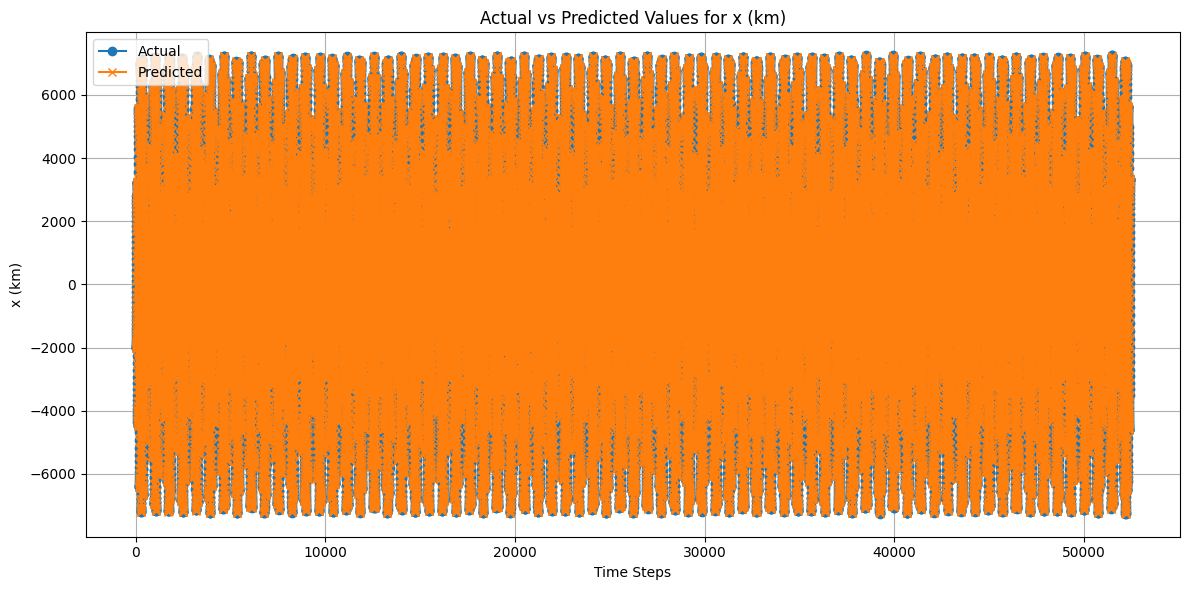

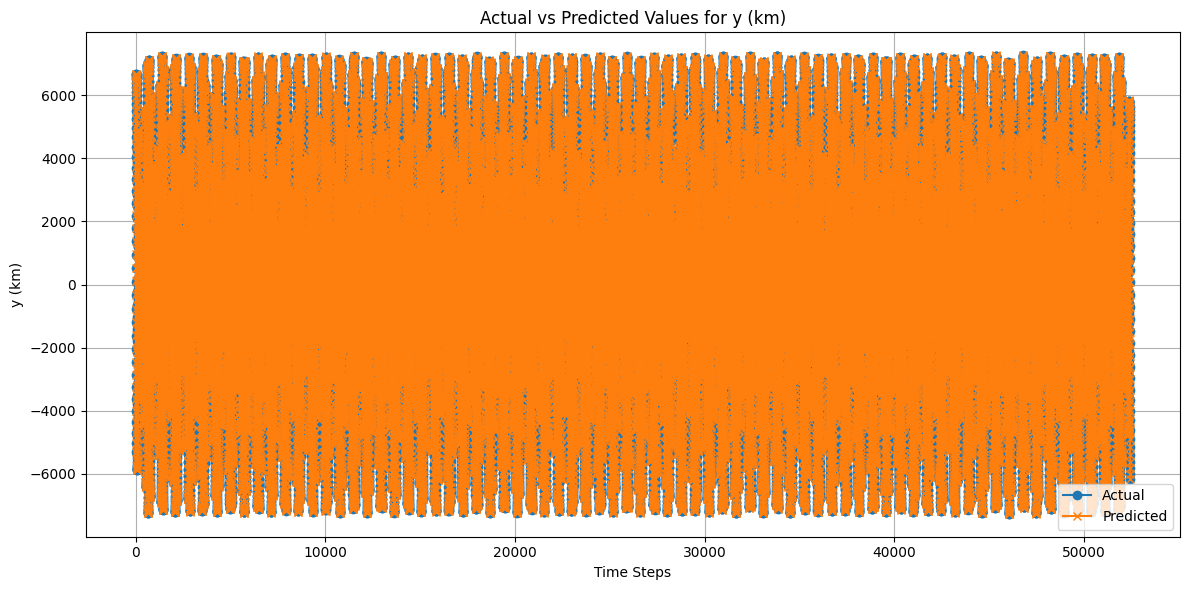

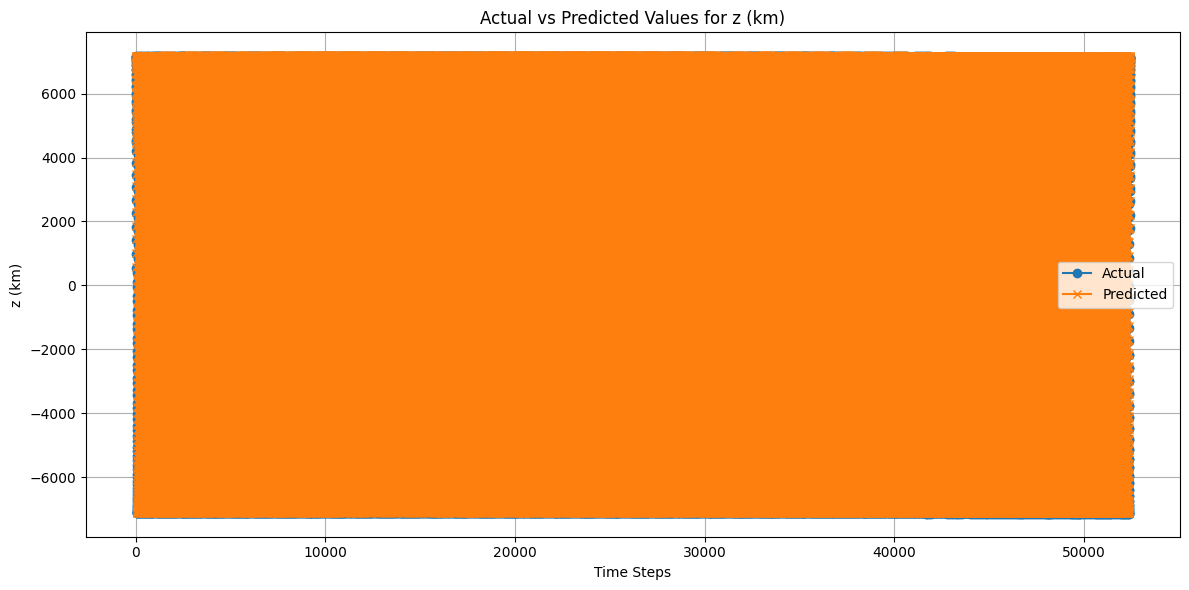

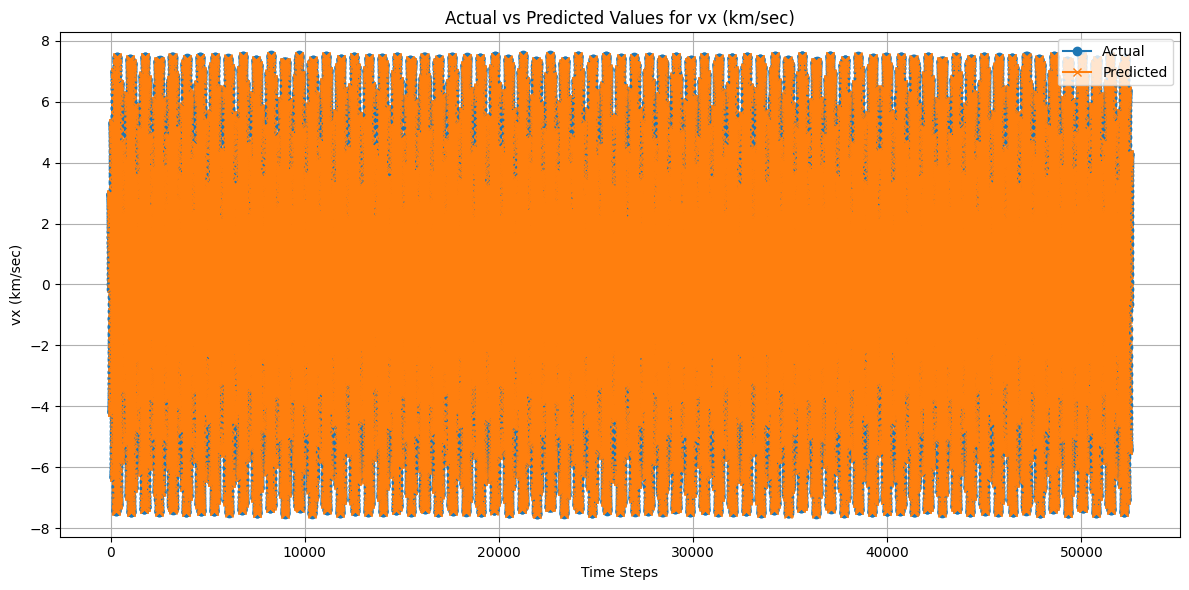

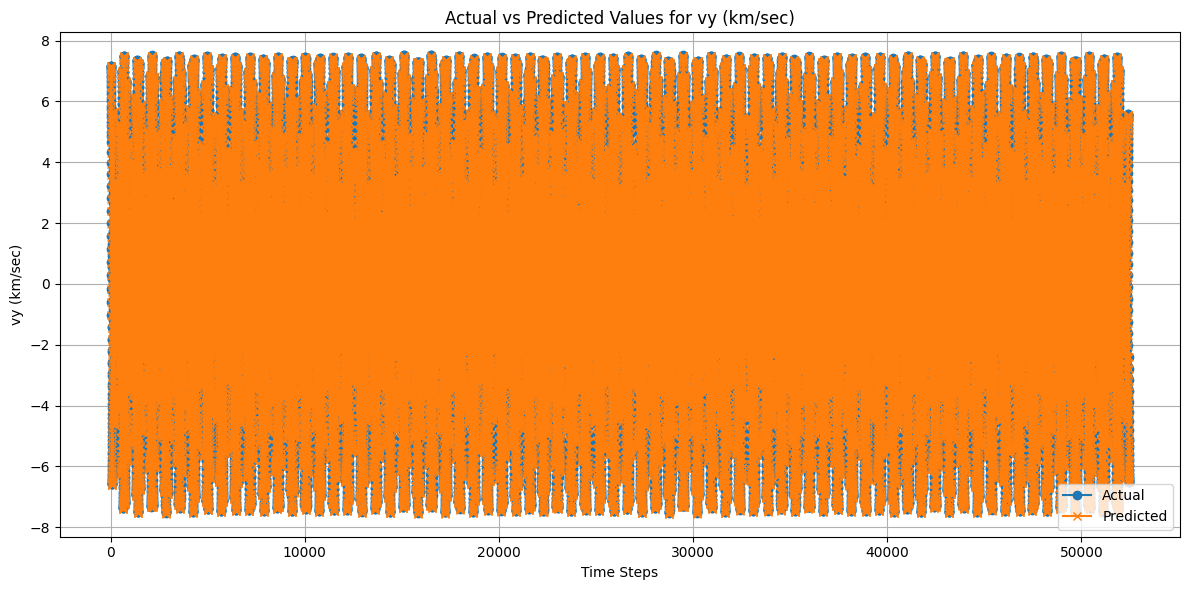

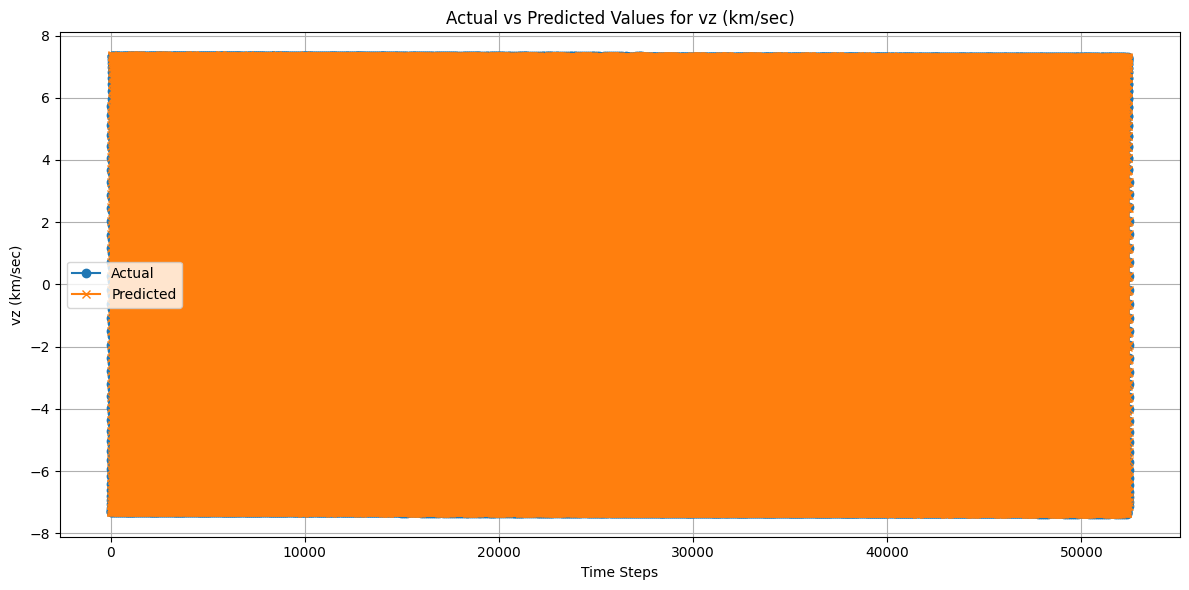

In [11]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted_split(y_actual, y_predicted, feature_name):
    plt.figure(figsize=(12, 6))
    plt.plot(y_actual, label='Actual', marker='o')
    plt.plot(y_predicted, label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted Values for {feature_name}')
    plt.xlabel('Time Steps')
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Assuming y_test_inv and test_predict are the actual and predicted values respectively
for feature_name in data.columns:
    feature_idx = data.columns.get_loc(feature_name)  # Get the index of the feature
    plot_actual_vs_predicted_split(y_test_inv[:, feature_idx], test_predict[:, feature_idx], feature_name)

In [12]:
from tensorflow.keras.models import load_model
import joblib

# Save the model
model.save('/content/drive/MyDrive/New prediction/C55006/C55000_model.h5')

# Save the scaler
joblib.dump(scaler, '/content/drive/MyDrive/New prediction/C55006/C55006scaler.pkl')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['/content/drive/MyDrive/New prediction/C55006/C55006scaler.pkl']